# Analyze A/B Test Results

---

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

---

<a id='intro'></a>
## Introduction

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

#### Group Description
Most experiments try to determine whether some type of experimental treatment (or important factor) has a significant effect on an outcome. Subjects who are chosen to participate in the experiment are typically divided into two groups:
* The **treatment group** consists of participants who receive the experimental treatment whose effect is being studied.
* The **control group** consists of participants who do not receive the experimental treatment being studied. Instead, they get a fake treatment or no treatment at all, depending on the situation.

In the end, the responses of those in the treatment group are compared with the responses from the control group to look for differences that are statistically significant (unlikely to have occurred just by chance).


In [3]:
# let's import required libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
%matplotlib inline
random.seed(42)

---

<a id='probability'></a>
## Part I - Probability

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [4]:
df=pd.read_csv('Dataset/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. The number of unique users in the dataset.

In [6]:
print ('Unique users: {}'.format(df.user_id.nunique()))
print ('Unique users in percentage: {}%'.format(df.user_id.nunique()*100/df.user_id.shape[0]))

Unique users: 290584
Unique users in percentage: 98.67766013080774%


d. The proportion of users converted.

In [7]:
print ('Proportion: {}'.format(df.converted.mean()))

Proportion: 0.11965919355605512


e. The number of times the `new_page` and `treatment` don't match.

In [8]:
a=df.query("(group!='treatment' and landing_page=='new_page') or (group=='treatment' and landing_page!='new_page')")['user_id'].count()
print ("Number of times didn't match: {}".format(a))
print ("Times didn't match in percentage: {}%".format(a*100/df.user_id.shape[0]))


Number of times didn't match: 3893
Times didn't match in percentage: 1.322000285250511%


f. Do any of the rows have missing values?

In [9]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.   

a. Assess the dataset and store new dataframe in **df2**.

In [10]:
df2=df.query("(group=='treatment' and landing_page=='new_page') or (group=='control' and landing_page=='old_page')")
df2=pd.DataFrame(df2)

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Clean **df2** dataframe. 

a. How many unique **user_id**s are in **df2**?

In [12]:
print ('Unique users: {}'.format(df2.user_id.nunique()))
print ('All users: {}'.format(df2.shape[0]))

Unique users: 290584
All users: 290585


b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2["is_duplicate"]= df2.user_id.duplicated()
df2.query("is_duplicate == True")

,user_id,timestamp,group,landing_page,converted,is_duplicate
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,True


c. What is the row information for the repeat **user_id**? 

In [14]:
df2.query("user_id == '773192'")

,user_id,timestamp,group,landing_page,converted,is_duplicate
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0,False
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,True


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2.drop(2893,inplace=True)
df2.drop(['is_duplicate'], axis=1, inplace=True)
df2.query("user_id=='2893'")

,user_id,timestamp,group,landing_page,converted


In [16]:
df2.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


`4.` Probability calculation in the cleaned dataframe. 

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
print('{}'.format(df2.converted.mean()))

0.11959708724499628


b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
df2[df2['group']=='control'].converted.mean()

0.1203863045004612

In [19]:
df2[df2['group']=='control'].user_id.count()

145274

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
df2[df2['group']=='treatment'].converted.mean()

0.11880806551510564

In [21]:
df2[df2['group']=='treatment'].user_id.count()

145310

d. What is the probability that an individual received the new page?

In [22]:
df2[df2['landing_page']=='new_page']['user_id'].count()/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

In [23]:
obs_diff = (df2[df2['group']=='treatment'].converted.mean())-(df2[df2['group']=='control'].converted.mean())
print('Coversion rate comparison within Treatment and Control groups is {}'.format (obs_diff))

Coversion rate comparison within Treatment and Control groups is -0.0015782389853555567


### Overview of Descriptive Statistic 
In this section we gathered descriptive statistic, that tells us:
> * The probability to receive the new page is 0.5, so its a fair comparison, because users have the same probability to land in one or other page
> * The conversion rate in the treatment group is 0.1188
> * While the conversion rate in the control group is 0.1203
> * The conversion rate difference is 0.0015 in the favour of the control group. 

Now we need to gather the inferential statistics in order to draw the conslusions that could lead to the right decision. 


---

<a id='ab_test'></a>
## Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  These questions are the difficult parts associated with A/B tests in general.  

`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

In [24]:
from IPython.display import Math
Math(r'H_{0}: \pi_{new} - \pi_{old} <= 0 \\ H_{1}: \pi_{new} - \pi_{old} > 0')

<IPython.core.display.Math object>

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. 

Use a sample size for each page equal to the ones in **ab_data.csv**. Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [25]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null?

In [26]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [27]:
n_new = df2[df2['landing_page']=='new_page'].user_id.nunique()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [28]:
n_old = df2[df2['landing_page']=='old_page'].user_id.nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [29]:
new_page_converted = np.random.choice([0, 1], size=n_new, p=[1-p_new, p_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [30]:
old_page_converted = np.random.choice([0, 1], size=n_old, p=[1-p_old, p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [31]:
sim_diff = new_page_converted.mean()-old_page_converted.mean()
sim_diff

0.0018561311370054456

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [32]:
p_diff = []

for _ in range(10000):
    new = np.random.choice([0, 1], size=n_new, p=[1-p_new, p_new]).mean()
    old = np.random.choice([0, 1], size=n_old, p=[1-p_old, p_old]).mean()
    p_diff.append(new-old)

i. Plot a histogram of the **p_diffs**. 

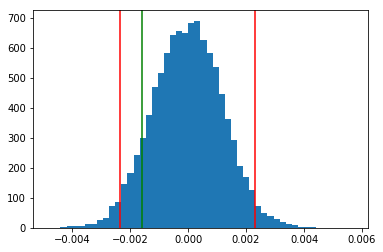

In [33]:
lower, upper = np.percentile(p_diff,2.5),np.percentile(p_diff,97.5)
plt.hist(p_diff,bins=50);
plt.axvline (obs_diff, color='g');
plt.axvline (lower, color='r');
plt.axvline (upper, color='r');


* The Central Limit Theorem states that with a large enough sample size the sampling distribution of the mean will be normally distributed which is in our case. 
* The Law of Large Numbers says that as our sample size increases, the sample mean gets closer to the population mean, which is close to 0.
* Observed proportion difference (green line) falls in the confidence interval (red lines). 

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [34]:
p_diffs = np.array(p_diff)
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
(null_vals > obs_diff).mean()

0.9045

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

Now we need to go back to the beginning of our work and check the significance level which was defined before starting testing A/B results. Significance level tells us how small the p-value must be to reject the test. For example, we decide either to reject the null hypothesis if the p-value is smaller than α, which in our case is 5%, or 0.05.

Now, in comparison of the p-value (0.907) together with a significance level (0.05), we see that our p-value exceeds α and the p-value is very high, which leads to conclude that we have weak evidence against the null hypothesis, therefore: **We fail to reject the null hypothesis.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [35]:
import statsmodels.api as sm

convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]
convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]


n_new = df2.query("landing_page == 'new_page'").shape[0]
n_old = df2.query("landing_page == 'old_page'").shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  

In [36]:
from statsmodels.stats.proportion import proportions_ztest
count = np.array([convert_old, convert_new])
nobs = np.array([n_old, n_new])
stat, pval = proportions_ztest(count, nobs, value=0, alternative='smaller')
print('{0:0.3f}'.format(pval))

0.905


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

Simulation and Z-test computed a very similar p-value, which means that the conclusions of the j. and k. steps are the same applicable here. 

### Overview of A/B Testing 

* Treating **a high p-value** / **low significance level** as evidence, by itself, that there is no effect, no difference between the means, is a common mistake. In order to use the p-value as a part of a decision process you need to consider external factors, which are a part of the experimental design process, which includes deciding on the significance threshold, sample size and power (power analysis), and the expected effect size, among other things.

* A/B testing also has its drawbacks. It can help you compare two options, but it can't tell you about an option you haven’t considered. It can also produce bias results when tested on existing users, due to factors like change aversion and novelty effect. **Change Aversion:** Existing users may give an unfair advantage to the old version, simply because they are unhappy with change, even if it’s ultimately for the better. **Novelty Effect:** Existing users may give an unfair advantage to the new version, because they’re excited or drawn to the change, even if it isn’t any better in the long run.

---

<a id='regression'></a>
## Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression, since the predict is 2 possible outcome [1, 0].**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
df3 = df2.copy()
df3[['control','ab_page']]=pd.get_dummies(df3['group'])
df3.drop(columns = ['control', 'group'],axis=1, inplace=True)
df3['intercept'] = 1
df3.head()

,user_id,timestamp,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,old_page,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [38]:
X = df3[['intercept','ab_page']]
y = df3['converted']

logit_mod = sm.Logit(y,X).fit();

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
logit_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 18 Jul 2019   Pseudo R-squ.:               8.077e-06
Time:                        16:47:16   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

p-value computed with logistic regression is 0.190, which is much lower comparing with the simulation or Z-test result. 

In the previous tests, I tested a hypothesis that predicted not only that the sample proportion would be different from the population proportion but that it would be different in a specific direction, called a directional or one‐tailed test. 

Logistic regression performed nondirectional or two‐tailed test.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

It would be interesting including user categories. This could highligh a different user behaviour based on the user characteristics.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  

In [41]:
df_countries=pd.read_csv('Dataset/countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [42]:
df3_merge=df3.merge(df_countries, left_on='user_id', right_on='user_id',how='outer')
df3_merge.head()

,user_id,timestamp,landing_page,converted,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,old_page,0,0,1,US
1,804228,2017-01-12 08:01:45.159739,old_page,0,0,1,US
2,661590,2017-01-11 16:55:06.154213,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,old_page,1,0,1,US


In [43]:
df3_merge[['CA','UK', 'US']]=pd.get_dummies(df3_merge['country'])
df3_merge.sample(3)

,user_id,timestamp,landing_page,converted,ab_page,intercept,country,CA,UK,US
288879,794456,2017-01-21 08:17:16.819249,old_page,0,0,1,US,0,0,1
92886,791531,2017-01-15 21:31:54.257741,old_page,0,0,1,US,0,0,1
253744,820889,2017-01-24 01:49:20.329252,old_page,0,0,1,US,0,0,1


In [44]:
df3_merge['UK_ab_page'] = df3_merge['UK']*df3_merge['ab_page']
df3_merge['US_ab_page'] = df3_merge['US']*df3_merge['ab_page']
df3_merge['CA_ab_page'] = df3_merge['CA']*df3_merge['ab_page']
df3_merge.sample(3)

,user_id,timestamp,landing_page,converted,ab_page,intercept,country,CA,UK,US,UK_ab_page,US_ab_page,CA_ab_page
72400,797263,2017-01-17 01:15:33.795386,new_page,1,1,1,US,0,0,1,0,1,0
219838,669056,2017-01-18 21:14:39.440744,old_page,0,0,1,US,0,0,1,0,0,0
16455,711512,2017-01-22 22:47:30.438757,new_page,0,1,1,US,0,0,1,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

In [45]:
X = df3_merge[['intercept', 'ab_page', 'US','CA', 'US_ab_page','CA_ab_page']]
y = df3_merge['converted']

Logit_mult = sm.Logit(y,X).fit()
Logit_mult.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 18 Jul 2019   Pseudo R-squ.:               3.482e-05
Time:                        16:47:32   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9922      0.016   -123.457      0.000      -2.024      -1.961
ab_page        0.0108      0.023      0.475      0.635      -0.034       0.056
US             0.0057      0.019      0.306      0.760      -0.031       0.043
CA            -0.0118      0.040     -0.296      0.767      -0.090       0.066
US_ab_page    -0.0314      0.027     -1.181      0.238      -0.084       0.021
CA_ab_page    -0.0783      0.057     -1.378      0.168      -0.190       0.033
==============================================================================
"""

An interaction between page and country shows a low significant effect on the page conversion.

### Last but not least :

* It is also important to take into consideration practical significance in making decisions. Practical significance takes into consideration other factors of your situation that might not be considered directly in the results of your hypothesis test or confidence interval. Constraints like space, time, or money are important in business decisions. 